In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
import os
import copy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

% matplotlib inline
warnings.filterwarnings('ignore')

In [36]:
data_transforms = {
    'flip': transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(p=1),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'notflip': transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
}

In [30]:
df_relation=pd.read_csv('./twins-relationship-info.csv')
df_relation.sample(3)
#df_relation.shape

,Unnamed: 0,subject_id1,subject_id2,relationship_type
159,160,nd1S90175,nd1S90174,Identical
104,105,nd1S90112,nd1S90115,UnknownTwinType
265,266,nd1S90305,nd1S90304,Identical


In [48]:
df=pd.read_csv('./image-metadata-3.0.csv')
df.sample(3)
#df.shape

,Unnamed: 0,filename,date,gender,race,yearofbirth,weather,glasses,expression,yaw,Unnamed: 9
14016,16835,90249d110.nef,2010-08-07 00:00:00,Male,White,1963,Inside,none,BlankStare,-90,90249d110.nef
2549,3013,90032d22.nef,2009-08-08 00:00:00,Female,White,1977,Inside,prism,Happiness,0,90032d22.nef
6021,7113,90081d62.nef,2009-08-08 00:00:00,Female,White,1948,Inside,none,BlankStare,0,90081d62.nef


In [49]:
class TwinsDataloader(Dataset):
    def __init__(self, dataroot, df_img, df_relations, transform):
        '''
        dataroot: path to folder with items
        df: pandas dataframe matadata(hasn't been changed)
        df_relatinos: pandas dataframe with relations between classes
        transform: torchvision flip and notflip transforms for  images(dict)
        '''
        self.dataroot = dataroot
        self.df = df[df[' yaw']==0]
        self.transform = transform
        self.relations=df_relations
        self.list_notexist=[]
    def __getitem__(self, index):
        
        def get_img_path(img_id):
            return self.dataroot+f'{img_id[:5]}/{img_id[:-4]}__face.jpg'
        
        monetochka=np.random.randint(0,2)
        #print(monetochka)
        id_a = self.df['filename'].iloc[index]
        img_a = Image.open(get_img_path(id_a))
        
        if monetochka==0: 
            find_id=self.relations['subject_id1'].str.find(id_a[:5])
            #print(find_id[find_id!=-1].index.tolist())
            if find_id[find_id!=-1].index.tolist():               
                id_b=self.relations['subject_id2'].iloc[find_id[find_id!=-1].index].values
                relation=self.relations['relationship_type'].iloc[find_id[find_id!=-1].index].values


                if relation[0] in ['Fraternal','Identical','IdenticalMirror','IdenticalTriplet']:
                    flag='Twins'
                    find_id=self.df['filename'].str.find(str(id_b[0][4:]))
                    id_b=self.df['filename'].loc[find_id[find_id!=-1].index[np.random.randint(0,len(find_id[find_id!=-1].index))]]
                    img_b = Image.open(get_img_path(id_b))
                    img_b=self.transform['notflip'](img_b)
                else:
                    id_b=id_a
                    img_b=img_a.copy()
                    img_b=self.transform['flip'](img_b)
                    flag='Not Twins'
            else:
                id_b=id_a
                img_b=img_a.copy()
                img_b=self.transform['flip'](img_b)
                flag='Not Twins'
        else:
            id_b=id_a
            img_b=img_a.copy()
            img_b=self.transform['flip'](img_b)
            flag='Not Twins'
    
        img_a = self.transform['notflip'](img_a)

        id_a=id_a[:5]
        id_b=id_b[:5]
        return {'img_a': img_a, 'img_b': img_b, 'class_a':id_a,'class_b':id_b,'label':flag}

    def __len__(self):
        return self.df.shape[0]

In [50]:
direct='./nd-twins-0006/faces/'
twins_dataset = TwinsDataloader(direct, df,df_relation ,data_transforms)

dataset = DataLoader(twins_dataset, batch_size=5,shuffle=True)

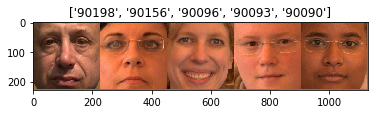

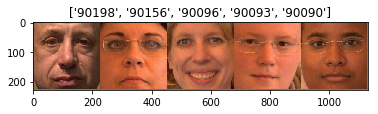

In [51]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
T = next(iter(dataset))

# Make a grid from batch
out = torchvision.utils.make_grid(T['img_a'])

imshow(out, title=[x for x in T['class_a']])

out = torchvision.utils.make_grid(T['img_b'])

imshow(out, title=[x for x in T['class_b']])

In [52]:
t=0
for _,T in enumerate(dataset):
    t+=len(T['class_a'])
    #out = torchvision.utils.make_grid(T['img_a'])
    #imshow(out, title=[x for x in T['class_a']])
    #out = torchvision.utils.make_grid(T['img_b'])
    #imshow(out, title=[x for x in T['class_b']])
print(t)

7418


## Detete inexisting photos from meta

In [106]:
with open('./inexist_photo.txt','r') as f:
    text=f.read()
text=text.split('\n')
print(len(text))

4318


In [104]:
df=pd.read_csv('./image-metadata-2.0.csv')
df.sample(3)

,filename,date,gender,race,yearofbirth,weather,glasses,expression,yaw,Unnamed: 9
20578,90341d27.nef,2010-08-07 00:00:00,Female,Black-or-African-American,1968,Inside,none,Happiness,-90,90341d27.nef
23158,90441d35.nef,2010-08-08 00:00:00,Male,White,1989,Inside,glasses,Happiness,-90,90441d35.nef
15463,90221d61.nef,2009-08-09 00:00:00,Female,White,1946,Sunny,prism,BlankStare,0,90221d61.nef


In [107]:
df.shape

(24050, 10)

In [125]:
for x in text:
    t=x+'.nef'
    find_id=df[df['filename']==t].index
    if find_id.tolist():
        df=df.drop([find_id[0]])

In [126]:
df.shape

(19736, 10)

In [129]:
df.to_csv('./image-metadata-3.0.csv')

In [ ]:
def train(model)